# Sound Similarity

In this notebook I use some math to determine which languages sound most like one another. The results are interesting.

Phonemes are the sounds that occur in a language. For instance, /kʰ/ is the first sound in the English word _king_, and /ŋ/ is the sound of _ng_. [The International Phonetic Alphabet](https://en.wikipedia.org/wiki/International_Phonetic_Alphabet) is the system that linguists use to transcribe the sounds of words - it lets us escape all the messiness of a particular language's spelling rules. In IPA, we'd transceibe the word "king" as /kʰɪŋ/. As you may have already noticed, linguists put IPA transcriptions inside of forward /slæʃɪz/.

You compare the sounds in different languages by simply counting which phonemes overlap. This is one of the methods that I employ below. However, when you look at the consonant chart in the IPA, you'll realize that just like words can be broken down into individual speech sounds, speech sounds themselves can be defined as combinations of a _place of articulation_ and a _manner of articulation_. For instance, the sound /kʰ/ is a _velar plosive_ - your tongue makes contact with the __velum__ in your mouth, and the sound __explodes__ outwards -- place of articulation: velar; manner of articulation: plosive. Speech sounds also have other attributes, like voicing (whether your vocal cords vibrate) - /kʰ/ is voiceless, but /g/ is its voiced counterpart.

What this means is that in addition to treating phonemes discretely, we can also break them down into their constituent attributes to get a more fine-grained measure of similarity. For instance /kʰ/ is more similar to /k/ than to /m/ (a bilabial nasal sound). I use both strategies when developing metrics.

All the data I'm using is from [Phoible](https://phoible.org/), so you can head over there and thank them 😃

## Data Acquisition

In this section, I download the Phoible dataset and get it into a format that's easy to work with. I perform some basic analyses to show you what the data looks like.

In [1]:
! curl https://raw.githubusercontent.com/phoible/dev/master/data/phoible.csv > phoible.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.0M  100 23.0M    0     0  3908k      0  0:00:06  0:00:06 --:--:-- 4472k


In [2]:
! mv phoible.csv ../data

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("../data/phoible.csv")

/Users/cameronsmith/anaconda3/envs/notebooks/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4,7,8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
df.head()

,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,Phoneme,Allophones,Marginal,SegmentClass,...,retractedTongueRoot,advancedTongueRoot,periodicGlottalSource,epilaryngealSource,spreadGlottis,constrictedGlottis,fortis,raisedLarynxEjective,loweredLarynxImplosive,click
0,1,kore1280,kor,Korean,NaN,0068,h,ç h ɦ,NaN,consonant,...,0,0,-,-,+,-,-,-,-,-
1,1,kore1280,kor,Korean,NaN,006A,j,j,NaN,consonant,...,0,0,+,-,-,-,-,-,-,-
2,1,kore1280,kor,Korean,NaN,006B,k,k̚ ɡ k,NaN,consonant,...,0,0,-,-,-,-,-,-,-,-
3,1,kore1280,kor,Korean,NaN,006B+02B0,kʰ,kʰ,NaN,consonant,...,0,0,-,-,+,-,-,-,-,-
4,1,kore1280,kor,Korean,NaN,006B+02C0,kˀ,kˀ,NaN,consonant,...,0,0,-,-,-,+,-,-,-,-


- include maps
- include language info

## Data Exploration

In this section I'm going to look at the overall distribution of language features and answer some basic questions: which languages have the largest phoneme inventories? Which languages are the most consonant-heavy, etc.

__TODO__: download table on "representation" - which phonemes are the rarest and which languages have them?

In [6]:
# All the features from SegmentClass onwards are phoneme- (segment) specific features.
df.columns

Index(['InventoryID', 'Glottocode', 'ISO6393', 'LanguageName',
       'SpecificDialect', 'GlyphID', 'Phoneme', 'Allophones', 'Marginal',
       'SegmentClass', 'Source', 'tone', 'stress', 'syllabic', 'short', 'long',
       'consonantal', 'sonorant', 'continuant', 'delayedRelease',
       'approximant', 'tap', 'trill', 'nasal', 'lateral', 'labial', 'round',
       'labiodental', 'coronal', 'anterior', 'distributed', 'strident',
       'dorsal', 'high', 'low', 'front', 'back', 'tense',
       'retractedTongueRoot', 'advancedTongueRoot', 'periodicGlottalSource',
       'epilaryngealSource', 'spreadGlottis', 'constrictedGlottis', 'fortis',
       'raisedLarynxEjective', 'loweredLarynxImplosive', 'click'],
      dtype='object')

In [7]:
# Get the data into SQL format so it's easier to run queries against.
from sqlalchemy import create_engine

engine = create_engine('sqlite://', echo=False)
df.to_sql('phoible', con=engine)

In [8]:
# Which languages have the largest number of phonemes?
# Group by `InventoryID, LanguageName` because some languages have dialects: `SpecificDialect` column
res = engine.execute("""
               SELECT LanguageName, COUNT(*) AS cnt
               FROM phoible
               GROUP BY InventoryID, LanguageName
               ORDER BY cnt DESC
               """
              ).fetchall()

# Show the first 10 results
res[:10]

[('!Xóõ', 161),
 ('!XU', 141),
 ('Soghpo Tibetan', 133),
 ('Kildin Saami', 128),
 ('!Xun', 120),
 ('Mbembe', 116),
 ('Nangchenpa Tibetan', 96),
 ('Lezgian', 96),
 ('Rigwe', 95),
 ('Hindi-Urdu', 94)]

<AxesSubplot:xlabel='# of phonemes', ylabel='# of languages'>

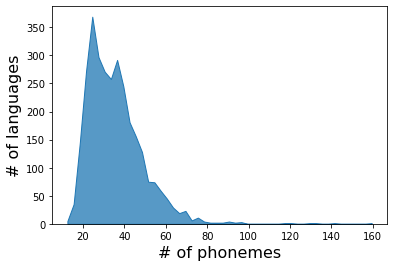

In [31]:
# Let's graph it
import seaborn as sns

plt.xlabel('# of phonemes', fontsize=16)
plt.ylabel('# of languages', fontsize=16)

sns.histplot(data=[i for _, i in res], bins=50, element="poly")

In [32]:
# Which languages have the smallest number of phonemes?
# Group by `InventoryID, LanguageName` because some languages have dialects: `SpecificDialect` column
engine.execute("""
               SELECT LanguageName, COUNT(*) AS cnt
               FROM phoible
               GROUP BY InventoryID, LanguageName
               ORDER BY cnt ASC
               LIMIT 10
               """
              ).fetchall()

[('PIRAHA', 11),
 ('ROTOKAS', 11),
 ('Pirahã', 11),
 ('HAWAIIAN', 13),
 ('NASIOI', 13),
 ('RORO', 14),
 ('TAORIPI', 14),
 ('Abau', 14),
 ('EKARI', 15),
 ('GADSUP', 15)]

In [33]:
# Which languages have the largest number of distinct vowels?
engine.execute("""
               SELECT LanguageName, COUNT(*) AS cnt
               FROM phoible
               WHERE SegmentClass = 'vowel'
               GROUP BY InventoryID, LanguageName
               ORDER BY cnt DESC
               LIMIT 10
               """
              ).fetchall()

[('So', 50),
 ('Elfdalian', 50),
 ('Danish', 49),
 ('Scottish Gaelic', 49),
 ('!XU', 46),
 ('PARAUK', 43),
 ('Dan', 40),
 ('Thok Reel', 40),
 ('Karimojong', 39),
 ('Luanyjang Dinka', 39)]

In [34]:
# Which languages have the fewest number of distinct vowels?
engine.execute("""
               SELECT LanguageName, COUNT(*) AS cnt
               FROM phoible
               WHERE SegmentClass = 'vowel'
               GROUP BY InventoryID, LanguageName
               ORDER BY cnt ASC
               LIMIT 10
               """
              ).fetchall()

[('Zulgo', 2),
 ('Cuvok', 2),
 ('Buwal', 2),
 ('Haida', 3),
 ('ARRERNTE', 3),
 ('ALABAMA', 3),
 ('QAWASQAR', 3),
 ('ALEUT', 3),
 ('AMUESHA', 3),
 ('WESTERN DESERT', 3)]

In [37]:
# Which languages have the highest consonant:vowel ratio?
res = engine.execute("""
               SELECT x.LanguageName, y.cons_cnt / CAST(x.vowel_cnt AS float) AS ratio FROM
               (SELECT InventoryID, LanguageName, COUNT(*) AS vowel_cnt
               FROM phoible x
               WHERE SegmentClass = 'vowel'
               GROUP BY InventoryID, LanguageName) AS x
               JOIN
               (SELECT InventoryID, LanguageName, COUNT(*) AS cons_cnt
               FROM phoible x
               WHERE SegmentClass = 'consonant'
               GROUP BY InventoryID, LanguageName) AS y
               ON x.InventoryID = y.InventoryID
               ORDER BY ratio DESC
               """
              ).fetchall()
res[:10]

[('Tashlhiyt Berber', 23.666666666666668),
 ('Abkhaz', 22.333333333333332),
 ('Abkhaz', 19.666666666666668),
 ('Buwal', 19.0),
 ('Adyghe', 18.666666666666668),
 ('Moroccan Arabic', 18.5),
 ('Haida', 15.666666666666666),
 ('HAIDA', 15.333333333333334),
 ('Zulgo', 14.5),
 ('Cuvok', 13.5)]

<AxesSubplot:xlabel='consonant/vowel ratio', ylabel='# of languages'>

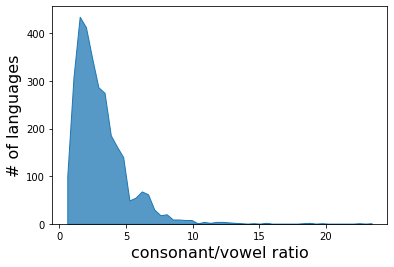

In [42]:
plt.xlabel('consonant/vowel ratio', fontsize=16)
plt.ylabel('# of languages', fontsize=16)

sns.histplot(data=[i for _, i in res], bins=50, element="poly")

In [48]:
# Which languages have tones?
engine.execute("""
               SELECT DISTINCT(LanguageName)
               FROM phoible
               WHERE tone = '+'
               LIMIT 15
               """
              ).fetchall()

[('Burushaski',),
 ('Vietnamese',),
 ('Mandarin Chinese',),
 ('Wu',),
 ('Hakka',),
 ('Cantonese',),
 ('Yao',),
 ('Dafla',),
 ('Burmese',),
 ('Lahu',),
 ('Karen',),
 ('Lakkia',),
 ('Thai',),
 ('Yay',),
 ('Cham',)]

In [75]:
# Which languages lack nasal sounds i.e. /n/, /m/?
engine.execute("""
               SELECT x.LanguageName, SUM(x.nasal) AS num_nasals
               FROM (SELECT InventoryID, LanguageName,
               CASE WHEN nasal = '-' THEN 0 ELSE 1 END AS nasal
               FROM phoible) AS x
               GROUP BY InventoryID, x.LanguageName
               ORDER BY num_nasals ASC
               LIMIT 16
               """
              ).fetchall()

# The final language, Najdi Arabic, definitely contains nasal sounds - so this might be an error!
# Error: https://github.com/phoible/dev/issues/332

[('LUSHOOTSEED', 0),
 ('PIRAHA', 0),
 ('QUILEUTE', 0),
 ('ROTOKAS', 0),
 ('Hup', 0),
 ('Tatuyo', 0),
 ('Xamtanga', 0),
 ('Pirahã', 0),
 ('Barasana-Eduria', 0),
 ('Kubeo', 0),
 ('Desano', 0),
 ('Máíhɨki', 0),
 ('Tatuyo', 0),
 ('Yurutí', 0),
 ('Pisamira', 0),
 ('Najdi Arabic', 0)]

## Language Comparison

In this section, I'm going to get the data into a format that's useful for doing comparisons. There are several ways to do this:

- Map each language to a list of all its phonemes, i.e. `"English": ["a", "e", "i", "b", ...]`
- Map each language to a vector representing the presence of absence of a given phoneme, i.e. `"English": [0, 0, 1, 0, ...]`. This binary vector is equal to the length of all the phonemes in the database.
- Map each language to a vector of vectors, where each sub-vector are the features of each phoneme, i.e `English: [[0, 1, 1, ...], [1, 1, 0, ...], ...]`

Each of these representations allow for different types of distance metrics, so I'll be trying out lots of measurement types. I took inspiration from [this paper](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Gardner_Measuring_Distance_Between_2014_CVPR_paper.pdf) about measuring the distances between sets.

Also, it's important to keep in mind the complexity of these different distance metrics. In order to determine the closest pair of languages, it's necessary to compute the distance between every pair of languages, which is $n^2$ computations. Furthermore, the distance metric itself has its own complexity, which I'll call $d$. That means the complexity of generating all the paired distances between all the languages is actually $dn^2$, which might be large. Luckily, we can ask specific questions instead, like _what is the distance between English and Arabic?_ which has a complexity of just $d$.

In [ ]:
# Create mappings like "English": ["a", "e", "i", "b", ...]


In [ ]:
# Apply the Jaccard distance metric
# https://en.wikipedia.org/wiki/Jaccard_index


In [ ]:
# Apply the overlap coefficient metric
# https://en.wikipedia.org/wiki/Overlap_coefficient


In [ ]:
# Apply the Steinhaus metric
# https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Gardner_Measuring_Distance_Between_2014_CVPR_paper.pdf


In [ ]:
# Apple the Tversky index metric
# https://en.wikipedia.org/wiki/Tversky_index
# Note: coef = 1 gives us Tanimoto, etc etc

In [ ]:
# Create mappings like "English": [0, 0, 1, 0, ...]


In [ ]:
# Apply the simple matching coefficient metric
# https://en.wikipedia.org/wiki/Simple_matching_coefficient


In [ ]:
# Apply hamming distance
# https://en.wikipedia.org/wiki/Hamming_distance


In [ ]:
# Create mappings like "English": [[0, 1, 1, ...], [1, 1, 0, ...], ...]


In [ ]:
# Custom distance metrics
